<a href="https://colab.research.google.com/github/ChandraMaddikunta/Week-4-lab/blob/master/Week_4_Lab_Neural_Networks_in_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Lab: Neural Networks in practice

# Chandra Maddikunta
* EAI6000

In [1]:
# Global imports and settings

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides


Using TensorFlow backend.


Using Keras 2.2.5


### Overview
* Solving basic classification and regression problems
* Handling textual data
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [0]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#### Understanding the format of IMDB dataset
1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
4. Print the first review to verify. 

In [4]:
train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [5]:
test_data

array([list([1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]),
       list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 2, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 2, 19, 861, 1074, 5, 1987, 2, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378, 270, 2352, 4, 1500, 7, 

In [6]:
len(train_data)

25000

In [7]:
len(test_data)

25000

In [8]:
len(train_data[0])

218

In [9]:
len(test_data[0])

68

In [10]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [11]:
x_train.size

250000000

In [12]:
x_test.size

250000000

In [13]:
x_train.shape

(25000, 10000)

In [14]:
x_test.shape

(25000, 10000)

* The length of the array corresponds to numbers of reviews. we have 25000 reviews in both train and test data. The length of the list corresponds to number words in the particular review.

* The sizes of x_train and x_test are 250000000 and shapes are (25000, 10000) 25000 corresponds to number of reviews. 10000 corresponds to One-Hot-Encoded format of each review, it is 10000 because total number of words in dataset are 10000 and each review is divided into 10000 values which are 0,1 . '0' when the review doesnt have the certain word, '1' when the review has that word.

In [0]:
import collections
import operator
def CountFrequency(arr): 
    return collections.Counter(arr) 

freq = CountFrequency(train_data[0])

In [16]:
freq.keys()

dict_keys([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 838, 112, 50, 670, 2, 9, 35, 480, 284, 150, 172, 167, 336, 385, 39, 4536, 1111, 17, 546, 38, 13, 447, 192, 6, 147, 2025, 19, 1920, 4613, 469, 71, 87, 12, 76, 15, 1247, 515, 626, 18, 62, 386, 8, 316, 106, 2223, 5244, 3785, 33, 130, 619, 124, 51, 135, 48, 1415, 215, 28, 77, 52, 407, 82, 107, 117, 5952, 7, 3766, 723, 476, 26, 400, 317, 46, 1029, 104, 88, 381, 297, 98, 32, 2071, 56, 141, 194, 7486, 226, 21, 134, 144, 30, 5535, 224, 92, 1334, 283, 4472, 113, 103, 5345, 178])

In [17]:
max(freq.items(), key=operator.itemgetter(1))

(4, 15)

In [18]:
reverse_word_index[4 - 3]

'the'

In [19]:
print("First review: ", ' '.join([reverse_word_index.get(i - 3, '') for i in train_data[0]][0:218]))

First review:   this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for  and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also  to the two little boy's that played the  of norman and paul they were just brilliant children are often left out of the  list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't

In [0]:
wordstring = [reverse_word_index.get(i - 3) for i in train_data[0]][1:219]
#wordstring

In [21]:
wordfreq = []
for w in wordstring:
    wordfreq.append(wordstring.count(w))

print("Pairs\n" + str(list(zip(wordstring, wordfreq))))

Pairs
[('this', 3), ('film', 6), ('was', 11), ('just', 4), ('brilliant', 3), ('casting', 1), ('location', 1), ('scenery', 1), ('story', 2), ('direction', 1), ("everyone's", 1), ('really', 2), ('suited', 1), ('the', 15), ('part', 1), ('they', 4), ('played', 2), ('and', 9), ('you', 4), ('could', 1), ('just', 4), ('imagine', 1), ('being', 2), ('there', 2), ('robert', 1), (None, 6), ('is', 1), ('an', 1), ('amazing', 3), ('actor', 1), ('and', 9), ('now', 1), ('the', 15), ('same', 2), ('being', 2), ('director', 1), (None, 6), ('father', 1), ('came', 1), ('from', 1), ('the', 15), ('same', 2), ('scottish', 1), ('island', 1), ('as', 3), ('myself', 1), ('so', 4), ('i', 3), ('loved', 1), ('the', 15), ('fact', 1), ('there', 2), ('was', 11), ('a', 3), ('real', 1), ('connection', 1), ('with', 2), ('this', 3), ('film', 6), ('the', 15), ('witty', 1), ('remarks', 1), ('throughout', 1), ('the', 15), ('film', 6), ('were', 2), ('great', 1), ('it', 6), ('was', 11), ('just', 4), ('brilliant', 3), ('so', 4),

from this we can see that word with word_index = 4 is repeated highest no of times i.e 15. and the word which is repeated highest number of times is 'the'.

#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* Use binary_crossentropy loss

In [22]:
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples


In [23]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=2,
                    validation_data=(x_val, y_val))




Train on 15000 samples, validate on 10000 samples
Epoch 1/20





 - 2s - loss: 0.5254 - acc: 0.7725 - val_loss: 0.3941 - val_acc: 0.8658
Epoch 2/20
 - 1s - loss: 0.3143 - acc: 0.9019 - val_loss: 0.3117 - val_acc: 0.8872
Epoch 3/20
 - 1s - loss: 0.2288 - acc: 0.9276 - val_loss: 0.3086 - val_acc: 0.8770
Epoch 4/20
 - 1s - loss: 0.1827 - acc: 0.9433 - val_loss: 0.3077 - val_acc: 0.8772
Epoch 5/20
 - 1s - loss: 0.1464 - acc: 0.9557 - val_loss: 0.2873 - val_acc: 0.8845
Epoch 6/20
 - 1s - loss: 0.1195 - acc: 0.9633 - val_loss: 0.3163 - val_acc: 0.8775
Epoch 7/20
 - 1s - loss: 0.0990 - acc: 0.9723 - val_loss: 0.3172 - val_acc: 0.8793
Epoch 8/20
 - 2s - loss: 0.0828 - acc: 0.9770 - val_loss: 0.3221 - val_acc: 0.8827
Epoch 9/20
 - 1s - loss: 0.0654 - acc: 0.9831 - val_loss: 0.3435 - val_acc: 0.8802
Epoch 10/20
 - 1s - loss: 0.0526 - acc: 0.9878 - val_loss: 0.3737 - val_acc: 0.8787
Epoch 11/20
 - 1s - loss: 0.0418 - acc: 0.9908 - val_loss: 0.3955 - val_acc: 0.8782
Epoch 12/20
 - 1s - loss: 0

#### Evaluate model performance during training
1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
2. Plot the training and validation accuracy as a function of the training epoch.

Hint: these quantities are contained in the dict history.history.

In [24]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


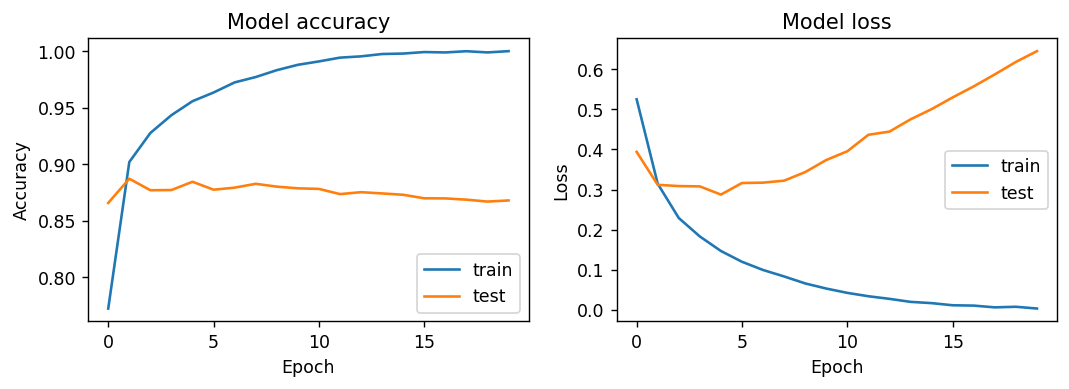

In [25]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

During the training model is intially a underfit model as the number of epochs increase underfitting decreases and the model reaches a good fit at a certain point but as the epochs increase more the model starts overfitting.

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs


In [26]:
#@title
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=2)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Epoch 1/4
 - 2s - loss: 0.2060 - acc: 0.9472
Epoch 2/4
 - 2s - loss: 0.1248 - acc: 0.9622
Epoch 3/4
 - 2s - loss: 0.0939 - acc: 0.9720
Epoch 4/4
 - 2s - loss: 0.0726 - acc: 0.9786
25000/25000 [==============================] - 2s 81us/step
Loss: 0.4837, Accuracy:  0.8618


#### Predictions
1. Print the first review that were correctly classified along with the predicted value.
2. Print the first review that were misclassified along with the predicted value. Can you explain why the model likely failed? How confident was the model?

In [0]:
y_pred = model.predict(x_test)
y_pred_class = model.predict_classes(x_test)

In [28]:
y_pred_class.astype('float32')

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [29]:
len(y_test)

25000

In [30]:
count = 0
count1 = 0
for i in range(25000):
  if count == 1 and count1 == 1:
    break 
  if y_test[i] == y_pred_class[i]:
    if count == 1:
      continue
    else :
      count = count + 1
      print("Correctly classified first review: ", ' '.join([reverse_word_index.get(j - 3, '') for j in test_data[i]][0:10000]), "\n predicted value is", y_pred[i], "\n Original value is", y_test[i])
  else :
    if count1 == 1:
      continue
    else :
      count1 = count1 + 1
      print("Wrongly classified first review: ", ' '.join([reverse_word_index.get(j - 3, '') for j in test_data[i]][0:10000]), "\n predicted value is", y_pred[i], "\n Original value is", y_test[i]) 

Correctly classified first review:   please give this one a miss br br   and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite  so all you madison fans give this a miss 
 predicted value is [0.010452] 
 Original value is 0.0
Wrongly classified first review:   i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because 

The model likely failed because in the begining of the review it was mentoined 'I generally love this kind of movie' which the model takes as positive review but the review was overall negitive. The model was not very confident about this prediction because the prediction value is only around 0.8. We can say that the model is very confident when the prediction value is more that 0.9.

#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. One can try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer


In [0]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [32]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=2,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=2,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.4445 - acc: 0.8200 - val_loss: 0.3260 - val_acc: 0.8855
Epoch 2/20
 - 4s - loss: 0.2580 - acc: 0.9095 - val_loss: 0.2876 - val_acc: 0.8884
Epoch 3/20
 - 4s - loss: 0.1971 - acc: 0.9306 - val_loss: 0.2908 - val_acc: 0.8840
Epoch 4/20
 - 4s - loss: 0.1675 - acc: 0.9404 - val_loss: 0.2970 - val_acc: 0.8819
Epoch 5/20
 - 4s - loss: 0.1456 - acc: 0.9491 - val_loss: 0.3411 - val_acc: 0.8714
Epoch 6/20
 - 4s - loss: 0.1270 - acc: 0.9554 - val_loss: 0.3454 - val_acc: 0.8732
Epoch 7/20
 - 4s - loss: 0.1119 - acc: 0.9610 - val_loss: 0.3576 - val_acc: 0.8734
Epoch 8/20
 - 4s - loss: 0.1016 - acc: 0.9651 - val_loss: 0.4064 - val_acc: 0.8647
Epoch 9/20
 - 4s - loss: 0.0884 - acc: 0.9701 - val_loss: 0.4128 - val_acc: 0.8678
Epoch 10/20
 - 4s - loss: 0.0788 - acc: 0.9734 - val_loss: 0.5112 - val_acc: 0.8510
Epoch 11/20
 - 4s - loss: 0.0729 - acc: 0.9758 - val_loss: 0.4638 - val_acc: 0.8620
Epoch 12/20
 - 4s - loss: 0.0605 - 

1. Plot the validation loss for the original and smaller models. How does the smaller model behave compared to the original?

In [33]:
original_hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [34]:
smaller_model_hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

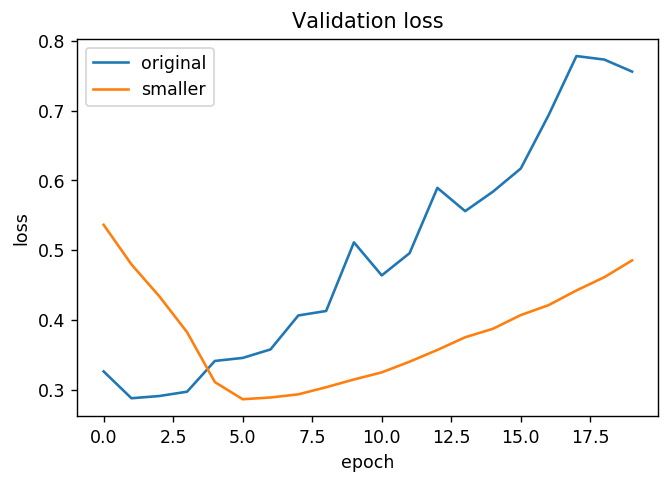

In [35]:

plt.plot(original_hist.history['val_loss'])
plt.plot(smaller_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['original', 'smaller'], loc='best')
plt.show()

We can see that smaller model has less validation loss than original model. Smaller model behaves similarly to original as in initially the loss decreases and then increases later but the smaller model has more decrease and less increase compared to original model.

### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [0]:
from keras import regularizers
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [38]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=2,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.4935 - acc: 0.8266 - val_loss: 0.3992 - val_acc: 0.8688
Epoch 2/20
 - 4s - loss: 0.3220 - acc: 0.9058 - val_loss: 0.3372 - val_acc: 0.8885
Epoch 3/20
 - 4s - loss: 0.2749 - acc: 0.9200 - val_loss: 0.3321 - val_acc: 0.8868
Epoch 4/20
 - 4s - loss: 0.2571 - acc: 0.9247 - val_loss: 0.3448 - val_acc: 0.8824
Epoch 5/20
 - 4s - loss: 0.2416 - acc: 0.9336 - val_loss: 0.3512 - val_acc: 0.8804
Epoch 6/20
 - 4s - loss: 0.2357 - acc: 0.9344 - val_loss: 0.3566 - val_acc: 0.8794
Epoch 7/20
 - 4s - loss: 0.2297 - acc: 0.9380 - val_loss: 0.3544 - val_acc: 0.8820
Epoch 8/20
 - 4s - loss: 0.2248 - acc: 0.9396 - val_loss: 0.3603 - val_acc: 0.8797
Epoch 9/20
 - 4s - loss: 0.2183 - acc: 0.9427 - val_loss: 0.3726 - val_acc: 0.8757
Epoch 10/20
 - 4s - loss: 0.2187 - acc: 0.9408 - val_loss: 0.3924 - val_acc: 0.8712
Epoch 11/20
 - 4s - loss: 0.2140 - acc: 0.9423 - val_loss: 0.3759 - val_acc: 0.8768
Epoch 12/20
 - 4s - loss: 0.2121 - 

1. Plot the validation loss for the original and l2 regularized models. How does the regularized model behave compared to the original?

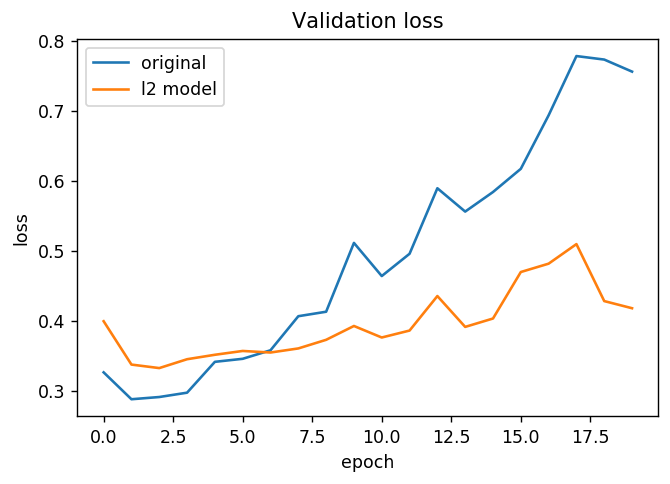

In [39]:
plt.plot(original_hist.history['val_loss'])
plt.plot(l2_model_hist.history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['original', 'l2 model'], loc='best')
plt.show()

We can see that loss in regularization model is much less than original model after the initial decrease the loss increases more in original model but the loss doesn't increase much in l2 model.

### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [40]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [41]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               
                               batch_size=512, verbose=2,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.6000 - acc: 0.6712 - val_loss: 0.4666 - val_acc: 0.8636
Epoch 2/20
 - 4s - loss: 0.4541 - acc: 0.8086 - val_loss: 0.3446 - val_acc: 0.8823
Epoch 3/20
 - 4s - loss: 0.3712 - acc: 0.8565 - val_loss: 0.2984 - val_acc: 0.8862
Epoch 4/20
 - 4s - loss: 0.3126 - acc: 0.8865 - val_loss: 0.2774 - val_acc: 0.8887
Epoch 5/20
 - 4s - loss: 0.2701 - acc: 0.9045 - val_loss: 0.2816 - val_acc: 0.8878
Epoch 6/20
 - 4s - loss: 0.2412 - acc: 0.9170 - val_loss: 0.2880 - val_acc: 0.8876
Epoch 7/20
 - 4s - loss: 0.2109 - acc: 0.9264 - val_loss: 0.3068 - val_acc: 0.8867
Epoch 8/20
 - 4s - loss: 0.1945 - acc: 0.9341 - val_loss: 0.3210 - val_acc: 0.8846
Epoch 9/20
 - 4s - loss: 0.1806 - acc: 0.9377 - val_loss: 0.3358 - val_acc: 0.8841
Epoch 10/20
 - 4s - loss: 0.1663 - acc: 0.9430 - val_loss: 0.3558 - val_acc: 0.8828
Epoch 11/20
 - 5s - loss: 0.1609 - acc: 0.9450 - val_loss: 0.3844 - val_acc: 0.8811
Epoch 12/20
 - 4s - loss: 0.1460 - 

1. Plot the validation loss for the original and dropout models. How does the dropout model behave compared to the original?

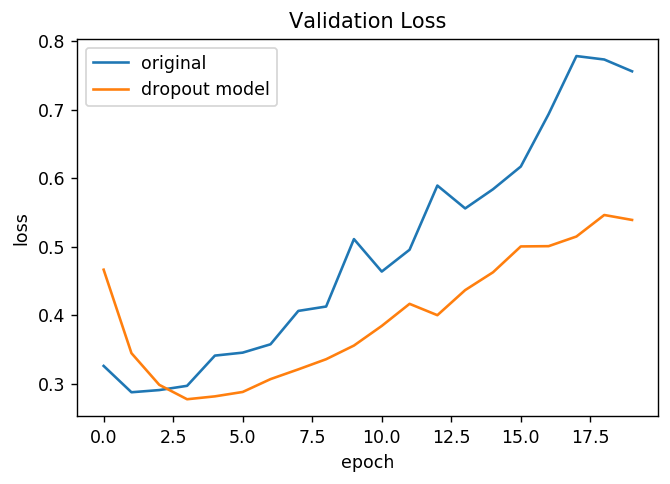

In [42]:
plt.plot(original_hist.history['val_loss'])
plt.plot(dpt_model_hist.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['original', 'dropout model'], loc='best')
plt.show()

Dropout model has low validation loss compared to original model it behaves similar to original but the increase in loss is less compared to original model.

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    


In [0]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

1. Create a function build_model that returns the neural network model described above

In [0]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* We can implement cross-validation ourselves (seeprovided code below)
* Alternatively, we can wrap a Keras model as a scikit-learn estimator
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    

In [46]:
# implementation of cross-validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


1. Train for longer (200 epochs) and keep track of loss after every epoch. Plot and describe the loss as a function of epoch number.

In [47]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=2)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)


processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/200
 - 0s - loss: 189.5231 - mean_absolute_error: 9.7193 - val_loss: 29.8549 - val_mean_absolute_error: 3.3870
Epoch 2/200
 - 0s - loss: 28.2157 - mean_absolute_error: 3.7588 - val_loss: 21.5973 - val_mean_absolute_error: 3.1671
Epoch 3/200
 - 0s - loss: 21.8756 - mean_absolute_error: 3.2798 - val_loss: 18.4388 - val_mean_absolute_error: 2.9236
Epoch 4/200
 - 0s - loss: 19.2032 - mean_absolute_error: 2.9664 - val_loss: 15.0946 - val_mean_absolute_error: 2.4792
Epoch 5/200
 - 0s - loss: 16.7426 - mean_absolute_error: 2.8069 - val_loss: 14.1276 - val_mean_absolute_error: 2.6467
Epoch 6/200
 - 0s - loss: 15.7732 - mean_absolute_error: 2.7412 - val_loss: 12.6754 - val_mean_absolute_error: 2.2586
Epoch 7/200
 - 0s - loss: 14.9331 - mean_absolute_error: 2.4916 - val_loss: 13.4779 - val_mean_absolute_error: 2.4694
Epoch 8/200
 - 0s - loss: 13.8334 - mean_absolute_error: 2.5055 - val_loss: 11.7487 - val_mean_absolute_er

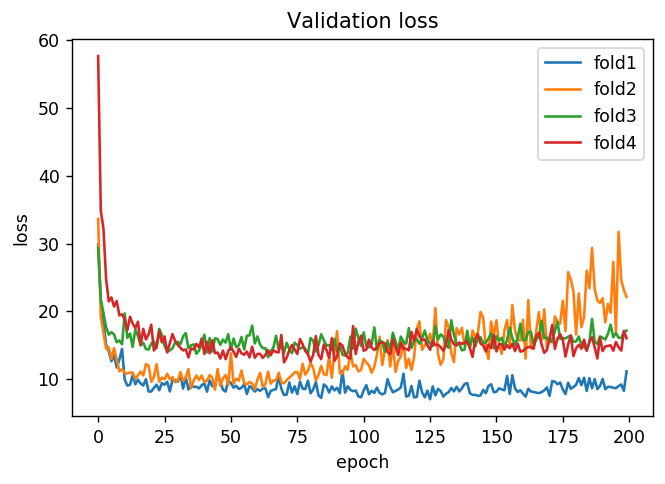

In [48]:
plt.plot(all_mae_histories[0])
plt.plot(all_mae_histories[1])
plt.plot(all_mae_histories[2])
plt.plot(all_mae_histories[3])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['fold1', 'fold2', 'fold3', 'fold4'], loc = 'best')
plt.show()

From the graph we can see that for all the folds loss initially decreases drastically after it oscillates up and down within a limited range without any drastic increase or decrease. Loss of other folds oscillate less compared to fold2 which changes more than others. Fold1 has the best loss compares to other folds.

#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs